In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


this doesn't have bootstrapping (so add this code to the cent_pop_ggm_boostrap_bic_vis notebook)

In [2]:
# data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0) #demo one matteo used
data = pd.read_csv("construct_ggm/pet_graphs/adni/adni_amy_tau_merged_cent_high_quartile.csv",index_col=0)
data.sample(3)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,...,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
RID,,,,,,,,,,,,,,,,,,,,,
6503,1.202,1.745,1.398,1.118,1.025,1.184,1.095,1.956,1.715,0.837,...,1.001,1.250,1.781,1.097,1.005,1.681,1.483,0.971,1.272,1.119
6809,1.176,1.367,1.250,1.114,0.860,0.969,0.988,1.271,1.636,0.667,...,0.880,1.013,1.219,1.003,0.966,1.179,0.879,0.932,1.138,0.979
6611,1.128,1.177,1.128,1.096,0.834,1.087,1.061,1.484,1.849,0.549,...,1.000,1.081,1.168,1.127,0.978,1.158,0.918,1.102,1.666,1.137


In [3]:
#check if centiloids col is there and drop it 
# data["CENTILOIDS"]
data = data.drop(columns="CENTILOIDS")
print(data.columns)

Index(['SUPRAMARGINAL', 'AMYGDALA', 'MIDDLETEMPORAL', 'PARSOPERCULARIS',
       'CAUDALANTERIORCINGULATE', 'INSULA', 'MEDIALORBITOFRONTAL',
       'ENTORHINAL', 'PUTAMEN', 'PERICALCARINE', 'ROSTRALANTERIORCINGULATE',
       'PRECUNEUS', 'THALAMUS', 'CAUDALMIDDLEFRONTAL', 'ACCUMBENS_AREA',
       'ISTHMUSCINGULATE', 'FRONTALPOLE', 'PARSTRIANGULARIS',
       'ROSTRALMIDDLEFRONTAL', 'SUPERIORPARIETAL', 'CAUDATE', 'LINGUAL',
       'LATERALORBITOFRONTAL', 'LATERALOCCIPITAL', 'PARSORBITALIS',
       'VENTRALDC', 'PRECENTRAL', 'TEMPORALPOLE', 'INFERIORPARIETAL',
       'TRANSVERSETEMPORAL', 'CUNEUS', 'PALLIDUM', 'INFERIORTEMPORAL',
       'POSTERIORCINGULATE', 'SUPERIORTEMPORAL', 'FUSIFORM', 'PARACENTRAL',
       'CEREBELLUM_CORTEX', 'PARAHIPPOCAMPAL', 'BANKSSTS', 'POSTCENTRAL',
       'HIPPOCAMPUS', 'SUPERIORFRONTAL'],
      dtype='object')


In [4]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

In [5]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [6]:
alphas = np.linspace(0.015,1.,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
    model.fit(data_scaled)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

  0%|          | 0/64 [00:00<?, ?it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.803e-01
  warnings.warn(
100%|██████████| 64/64 [00:04<00:00, 13.88it/s]


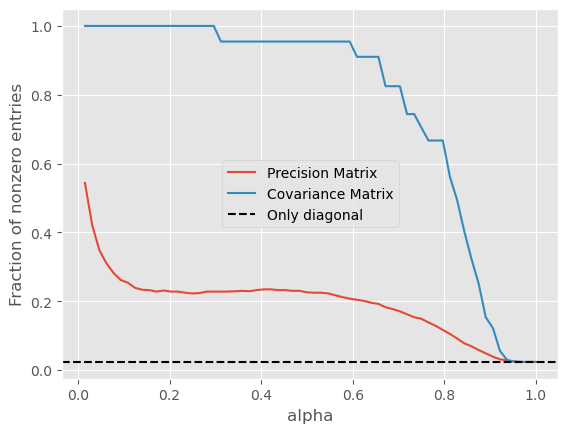

In [7]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend()

# Make graphs

In [8]:
model = GraphicalLasso(alpha=0.7, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
model.fit(data_scaled)

GraphicalLasso(alpha=0.7, assume_centered=True, eps=1e-12, max_iter=1000,
               tol=0.01)

Text(0.5, 1.0, 'Covariance')

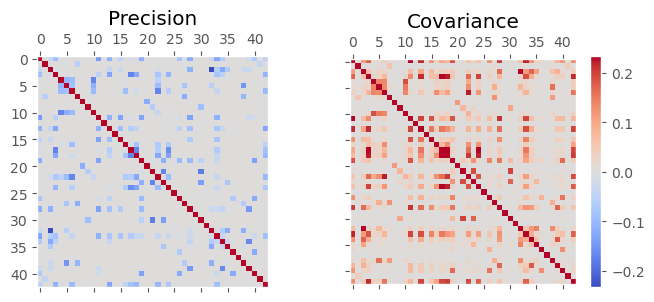

In [9]:
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)

im = axs[0].matshow(model.precision_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[0].grid()
# plt.colorbar(im,ax=axs[0])
axs[0].set_title("Precision")
# axs[0].axis('off')

im = axs[1].matshow(model.covariance_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[1].grid()
plt.colorbar(im,ax=axs[1])
axs[1].set_title("Covariance")
# axs[1].axis('off')

In [10]:
adj = np.copy(model.precision_)

np.fill_diagonal(adj, 0) # remove self connections 

G = nx.Graph(adj)

node_labels = {i: label.rsplit('_',1)[0] for i, label in enumerate(data_scaled.columns)}

G = nx.relabel_nodes(G, node_labels)


In [24]:
#print degrees from highest to lowest 
#first convert to a list of tuples and then sort from highest to lowest 
highest_deg = sorted(G.degree(), key=lambda x: x[1], reverse=True)
print(highest_deg)

[('POSTERIORCINGULATE', 18), ('SUPRAMARGINAL', 15), ('CAUDALMIDDLEFRONTAL', 13), ('MIDDLETEMPORAL', 12), ('PARSOPERCULARIS', 12), ('LATERALORBITOFRONTAL', 12), ('PRECUNEUS', 11), ('INFERIORPARIETAL', 11), ('SUPERIORFRONTAL', 11), ('MEDIALORBITOFRONTAL', 10), ('PARSTRIANGULARIS', 10), ('SUPERIORPARIETAL', 10), ('ROSTRALMIDDLEFRONTAL', 9), ('PARSORBITALIS', 9), ('SUPERIORTEMPORAL', 9), ('INSULA', 8), ('INFERIORTEMPORAL', 8), ('FRONTALPOLE', 7), ('PRECENTRAL', 7), ('CAUDALANTERIORCINGULATE', 6), ('ISTHMUSCINGULATE', 6), ('FUSIFORM', 6), ('PARAHIPPOCAMPAL', 6), ('BANKSSTS', 6), ('POSTCENTRAL', 6), ('AMYGDALA', 4), ('ROSTRALANTERIORCINGULATE', 4), ('LINGUAL', 4), ('LATERALOCCIPITAL', 4), ('TEMPORALPOLE', 4), ('CUNEUS', 4), ('ENTORHINAL', 3), ('PERICALCARINE', 2), ('PARACENTRAL', 2), ('PUTAMEN', 1), ('CAUDATE', 1), ('VENTRALDC', 1), ('PALLIDUM', 1), ('HIPPOCAMPUS', 1)]


In [27]:
# Create a colormap for node colors based on node degrees
# node_colors = list(node_degrees.values())

Identify and drop the nodes with no connections

In [28]:
isolates = list(nx.isolates(G))
isolates

[]

In [29]:
G.remove_nodes_from(isolates)

In [30]:
connected_components = list(nx.connected_components(G))
len(connected_components)

3

/tmp/ipykernel_3266744/2838395939.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


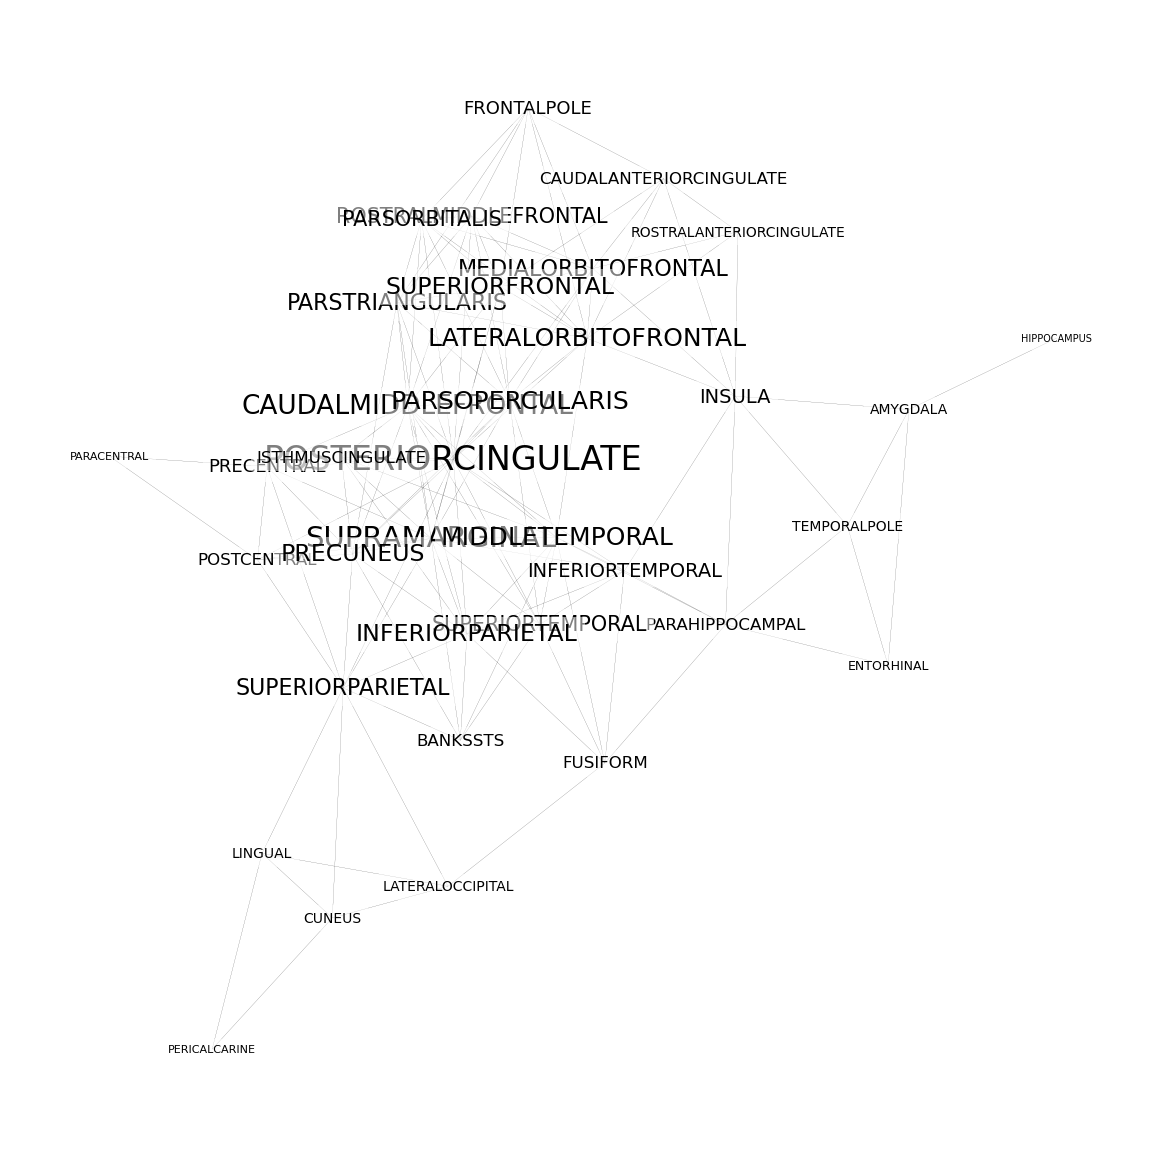

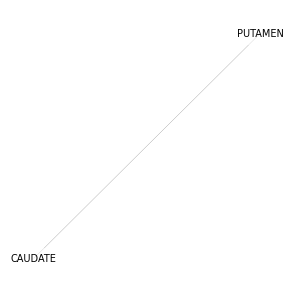

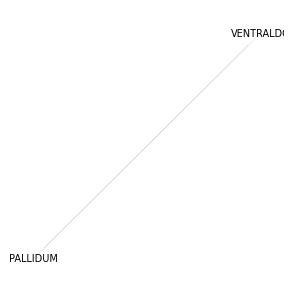

In [31]:
#  Draw the graph with node sizes and colors

for component in connected_components:

    g = G.subgraph(component)

    node_degrees = dict(g.degree())
    node_sizes = [64 * node_degrees[node] for node in g.nodes()]

    L = np.sqrt(len(component))*2.5

    fig,ax = plt.subplots(1,1,figsize=(L,L))
    pos = nx.circular_layout(g)
    pos = nx.kamada_kawai_layout(g,pos=pos,weight=None)
    # pos = nx.spring_layout(g,k=.6,pos=pos,weight=None)

    for node in component:
        nx.draw_networkx_labels(
            G.subgraph(node),
            pos={node:pos[node]},
            font_size=6+G.degree[node],
            bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
            ax=ax
        )

    nx.draw_networkx_edges(
        g,
        pos,
        width=0.1,
        # style='dashed',
        ax=ax
    )

    ax.axis('off');

# Hubs
Let's take a look at nodes that are highly connected. Do they form triangles?

In [33]:
pos = nx.kamada_kawai_layout(G["POSTERIORCINGULATE"])

The following code shows node neighborhoods 
- If a node has more than one connection (degree>1), then it plots a subgraph of that node and it's connections 
- for conditional dependence, I should be looking for nodes where the central node 

/tmp/ipykernel_3266744/1882518976.py:22: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(
/tmp/ipykernel_3266744/1882518976.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1,figsize=(6,4))


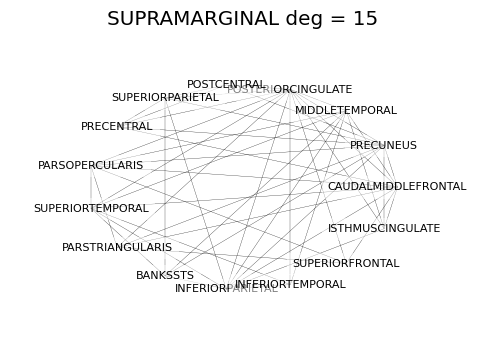

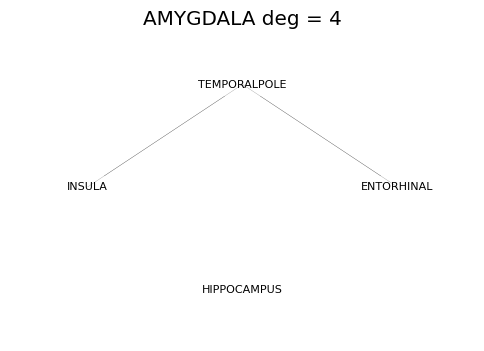

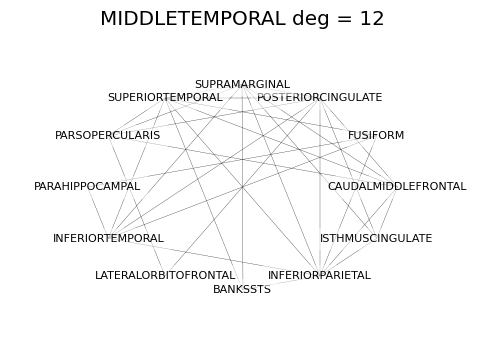

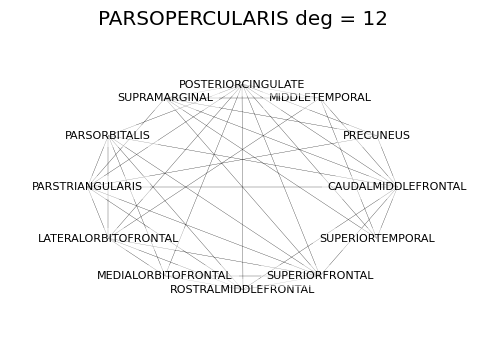

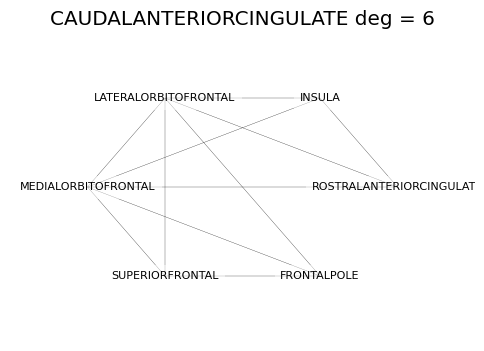

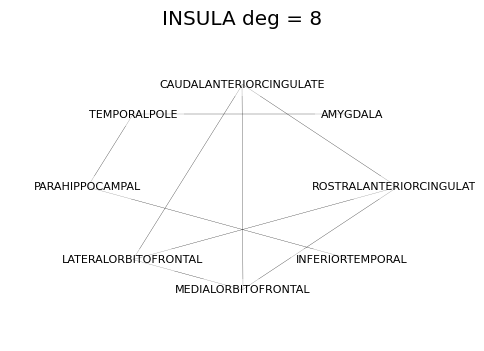

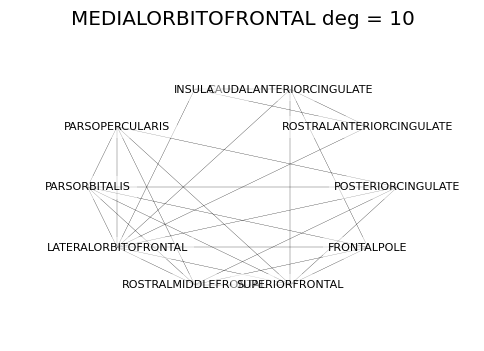

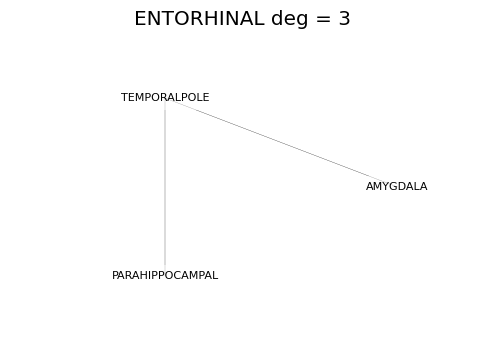

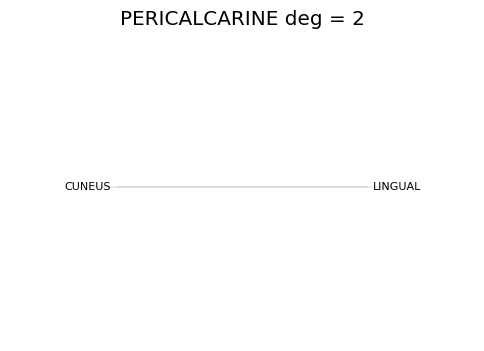

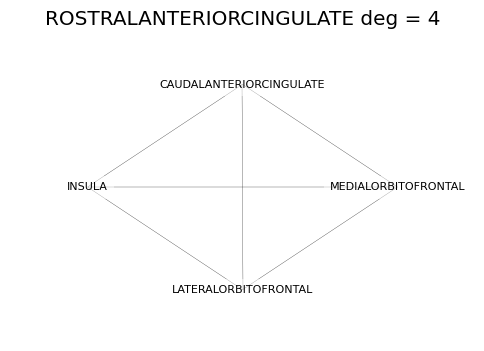

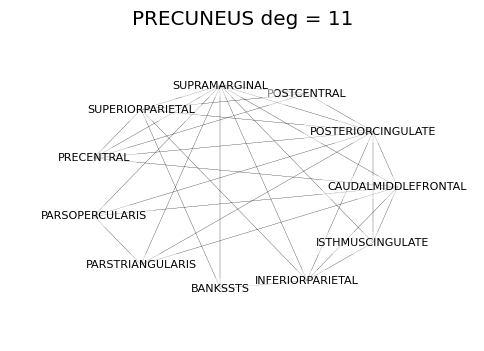

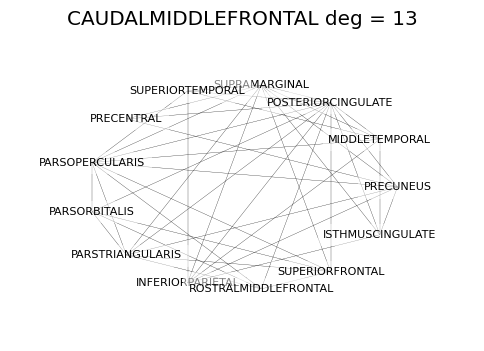

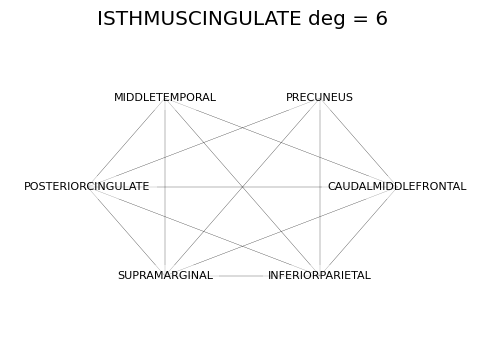

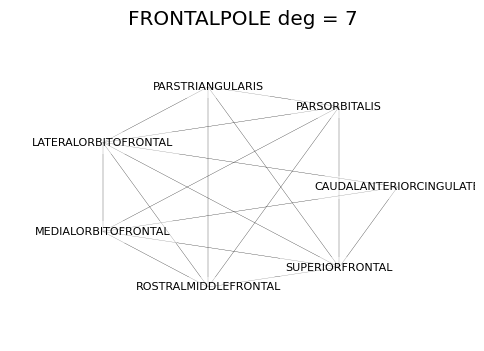

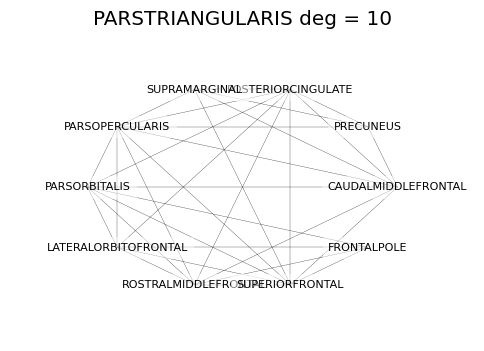

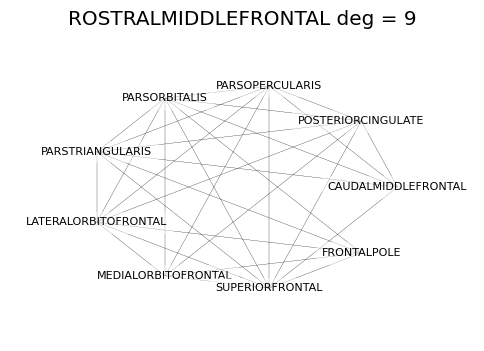

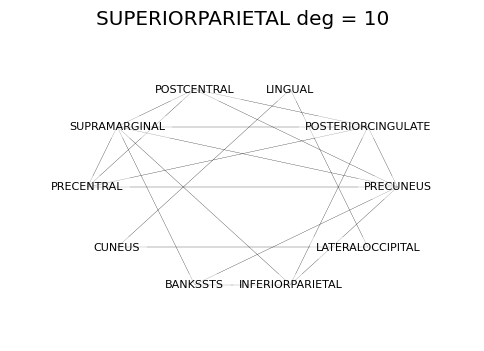

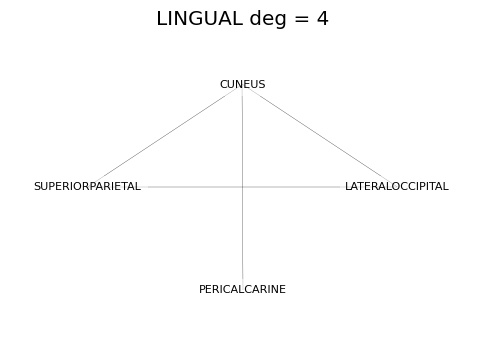

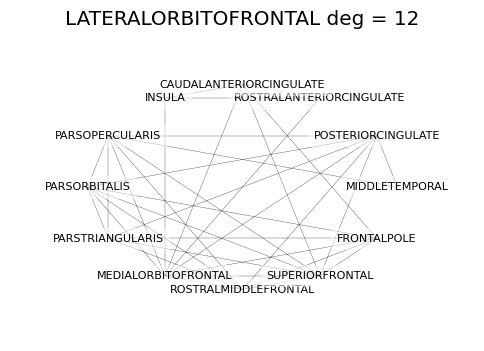

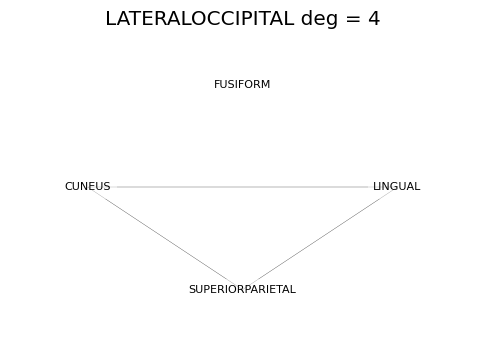

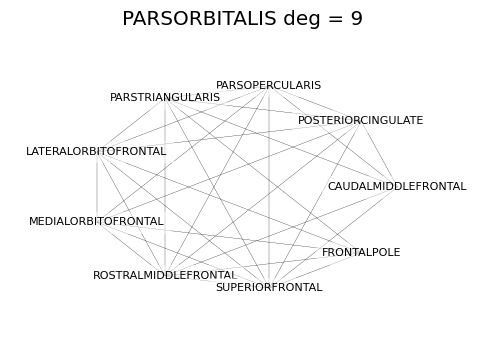

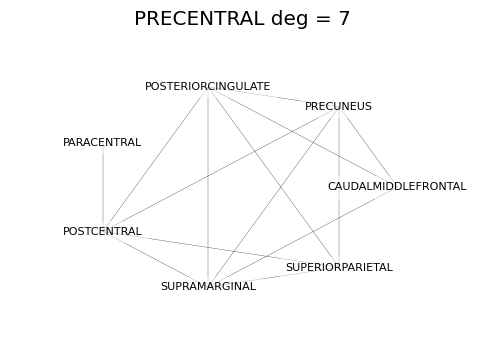

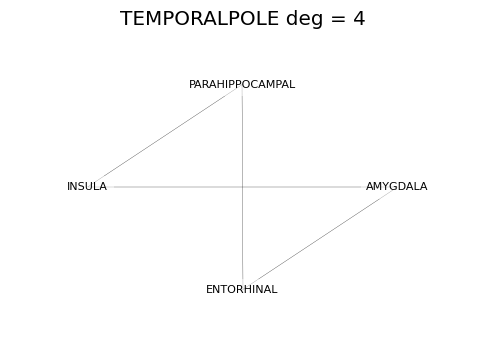

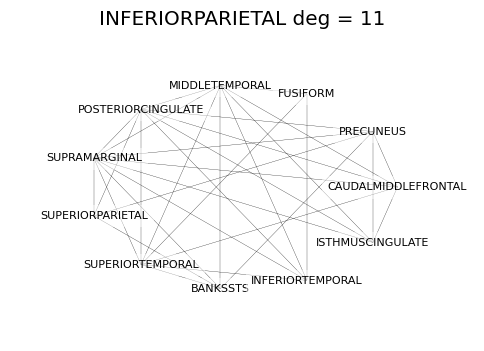

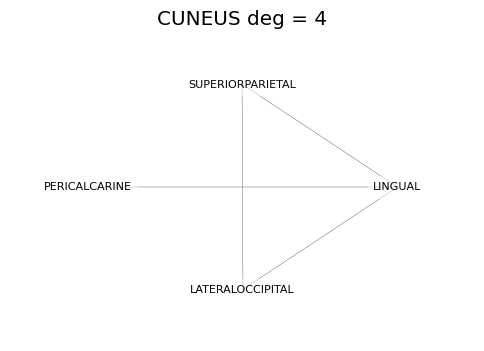

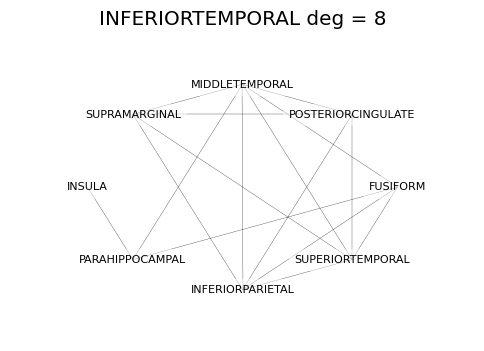

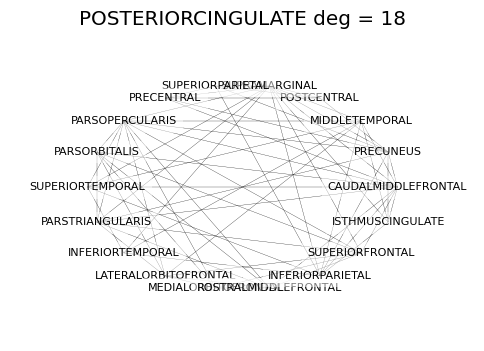

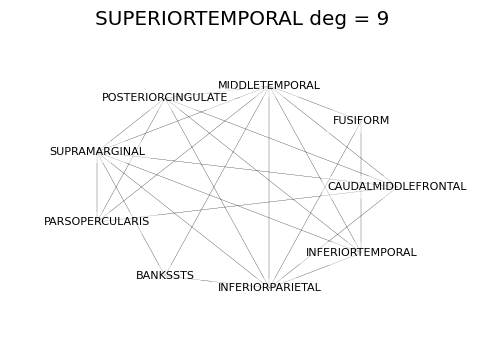

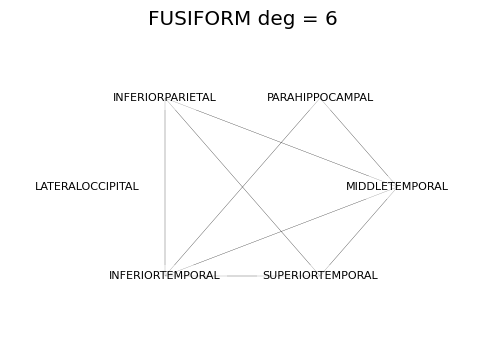

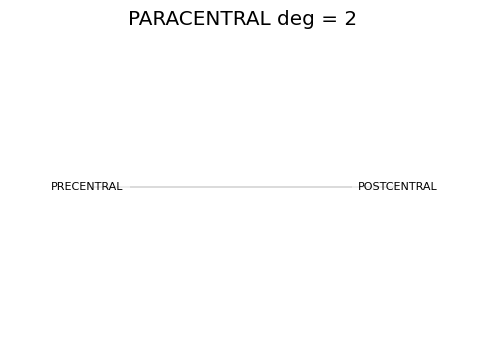

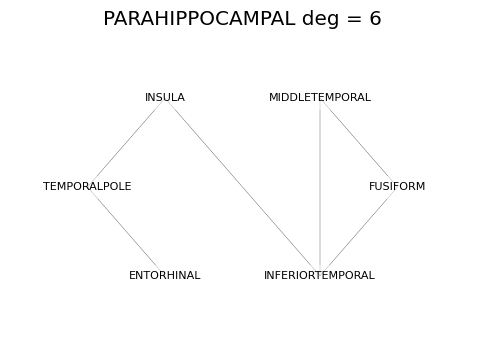

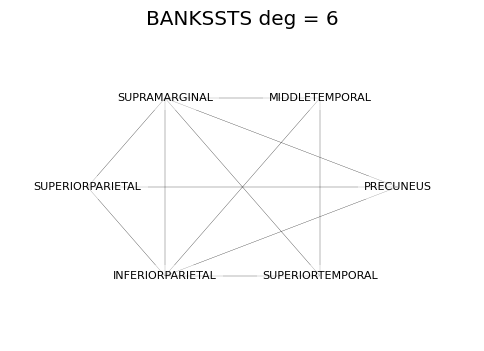

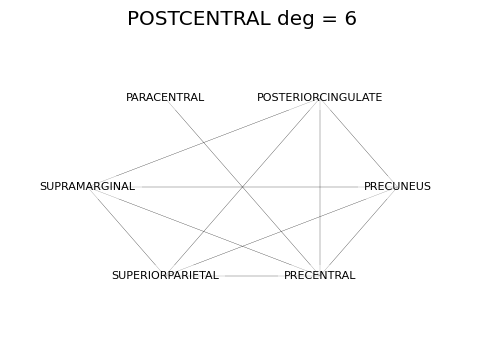

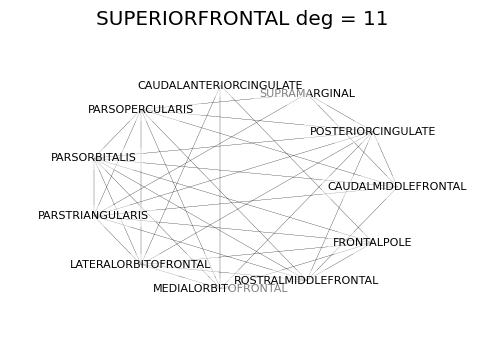

In [34]:
for node, degree in G.degree:
    
    if degree > 1:

        fig,ax = plt.subplots(1,1,figsize=(6,4))

        g = G.subgraph(G.neighbors(node))

        pos = nx.circular_layout(g)
        # pos = nx.kamada_kawai_layout(g,pos,weight=None)

        for n in g:
            nx.draw_networkx_labels(
                G.subgraph(n),
                pos={n:pos[n]},
                # font_size=6+G.degree[n],
                font_size=8,
                bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
                # ax=ax
            )

        nx.draw_networkx_edges(
            g,
            pos,
            width=.2,
            # style='dashed',
            # ax=ax
        )

        ax.set_xlim(left=-1.5,right=1.5)
        ax.set_ylim(bottom=-1.5,top=1.5)
        
        ax.set_title(node+" deg = "+str(degree))
        ax.axis('off')